In [10]:
## Imports
## System imports
import os
import sys

## Add root directory to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))

## LangChain
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver

## Python packages
import pandas as pd
from dotenv import load_dotenv
from datetime import datetime
from pprint import pprint
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display

## Self-defined modules
from utils import calculations, prompts

In [3]:
load_dotenv()
assert os.environ["LANGCHAIN_API_KEY"], "Please set the LANGCHAIN_API_KEY environment variable"
assert os.environ["GROQ_API_KEY"], "Please set the GROQ_API_KEY environment variable"
assert os.environ["OPENAI_API_KEY"], "Please set the OPENAI_API_KEY environment variable"

In [22]:
## Creating graph

class State(TypedDict):
    ## Messages have the type "list"
    ## The add_mesasges function in the annotation defines how this state key should be updated
    ## ie. it appends messages to the list, rather than overwriting it
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

## Add LLM node to graph
openai_llm = ChatOpenAI(model="gpt-3.5-turbo", api_key=os.environ["OPENAI_API_KEY"], )

def generator(state: State):
    return {"messages": [openai_llm.invoke(state["messages"])]}

graph_builder.add_node("generator", generator) ## Node name, function to be called

## Add edges
graph_builder.add_edge(START, "generator")
graph_builder.add_edge("generator", END)

graph = graph_builder.compile()

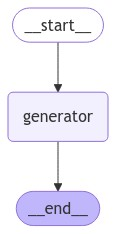

In [23]:
## Visualize graph
def draw_graph(graph):
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except:
        print("Error displaying graph")

draw_graph(graph)

In [25]:
## Run the graph
def stream_graph_updates(graph, user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("LLM:", value["messages"][-1].content)

example_input = "What is the best place to visit for nature lovers?"

pprint(stream_graph_updates(graph, example_input))

LLM: There are many incredible places around the world that are perfect for nature lovers, but some of the best include:

1. Yellowstone National Park in the United States: Known for its geothermal features, wildlife, and stunning landscapes, Yellowstone is a must-visit for nature enthusiasts.

2. Banff National Park in Canada: This beautiful national park in the Canadian Rockies offers breathtaking mountain scenery, crystal-clear lakes, and abundant wildlife.

3. The Amazon Rainforest in South America: The Amazon is the largest tropical rainforest in the world and is home to an incredible array of plant and animal species.

4. The Serengeti National Park in Tanzania: This iconic African safari destination is known for its vast savannahs, diverse wildlife, and the annual wildebeest migration.

5. The Great Barrier Reef in Australia: This UNESCO World Heritage Site is the largest coral reef system in the world and offers amazing opportunities for snorkeling and diving.

Ultimately, the 

In [35]:
## Adding memory
memory = MemorySaver()
graph_with_memory = graph_builder.compile(checkpointer=memory)

## Run the graph
config_1 = {"configurable": {"thread_id": "1"}}

def stream_graph_memory(graph, user_input: str, config):
    events = graph.stream({"messages": [("user", user_input)]}, config=config, stream_mode="values")
    for event in events:
        event["messages"][-1].pretty_print()

stream_graph_memory(graph_with_memory, "I love going on nature walks", config_1)
stream_graph_memory(graph_with_memory, "Where do you recommend I visit?", config_1)

================================ Human Message =================================

I love going on nature walks
================================== Ai Message ==================================

and soaking in the beauty of the great outdoors. The fresh air, the sound of birds chirping, and the sight of lush greenery all around me bring me a sense of peace and tranquility. I enjoy taking in the sights and sounds of nature, whether it's a leisurely stroll through a park or a more challenging hike through the mountains. Nature walks are a great way for me to clear my mind, de-stress, and reconnect with the natural world. There's something about being surrounded by nature that rejuvenates my soul and fills me with a sense of wonder and awe. I always come back from a nature walk feeling refreshed, inspired, and grateful for the beauty that surrounds us.
================================ Human Message =================================

Where do you recommend I visit?
==========================

In [36]:
## Use another thread
config_2 = {"configurable": {"thread_id": "2"}}

stream_graph_memory(graph_with_memory, "I love eating Japanese food", config_2)
stream_graph_memory(graph_with_memory, "Where do you recommend I visit?", config_2)

================================ Human Message =================================

I love eating Japanese food
================================== Ai Message ==================================

! It's so delicious and flavorful. Some of my favorite dishes include sushi, ramen, tempura, and teriyaki. The combination of fresh ingredients and unique flavors always leaves me feeling satisfied. Plus, the presentation of Japanese food is always so beautiful and artistic. I could eat Japanese food every day and never get tired of it!
================================ Human Message =================================

Where do you recommend I visit?
================================== Ai Message ==================================

If you're looking to try authentic Japanese cuisine, I highly recommend visiting Japan itself. Tokyo, Kyoto, and Osaka are known for their amazing food scene, with countless restaurants offering traditional dishes and modern twists on classic favorites. In Tokyo, you can v

In [37]:
## Check memory
snapshot = graph_with_memory.get_state(config_1)
print("Thread 1: ", snapshot)

snapshot = graph_with_memory.get_state(config_2)
print("Thread 2: ", snapshot)

Thread 1:  StateSnapshot(values={'messages': [HumanMessage(content='I love going on nature walks', additional_kwargs={}, response_metadata={}, id='b72d465c-8d23-475a-93af-558df99c40de'), AIMessage(content="and soaking in the beauty of the great outdoors. The fresh air, the sound of birds chirping, and the sight of lush greenery all around me bring me a sense of peace and tranquility. I enjoy taking in the sights and sounds of nature, whether it's a leisurely stroll through a park or a more challenging hike through the mountains. Nature walks are a great way for me to clear my mind, de-stress, and reconnect with the natural world. There's something about being surrounded by nature that rejuvenates my soul and fills me with a sense of wonder and awe. I always come back from a nature walk feeling refreshed, inspired, and grateful for the beauty that surrounds us.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 141, 'prompt_tokens': 13, 'total

Applying to report generation task